# Points

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this case, analysis of points is very similar to that of other types of spatial data such as polygons and lines. On the other hand, points can be seen as the occurence of an event that could theoretically take place anywhere but only manifests in certain locations. This is the approach we will adopt in the rest of the notebook.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is crime events in a city: they could technically happen in many locations but we usually find crimes are committed only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occured are provided. Continuing the crime example, an unmarked pattern would result if only the location where crimes were committed was used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the type of crime, the extent of the damage, etc. was provided with the location.

Point pattern analysis is thus concerned with the description, statistical characerization, and modeling of point patterns, focusing specially on the generating process that gives rise and explains the observed data. *What's the nature of the distribution of points?* *Is there any structure we can statistically discern in the way locations are arranged over space?* *Why do events occur in those places and not in others?* These are all questions that point pattern analysis is concerned with.

This notebook aims to be a gentle introduction to working with point patterns in Python. As such, it covers how to read, process and transform point data, as well as several common ways to visualize point patterns.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point

## Data

We are going to dip our toes in the lake of point data by looking at a sample of geo-referenced tweets in the city of Liverpool. The dataset we will be playing with contains the location of over 130,000 messages posted on Twitter from January to the end of October of 2012. A detailed description of the variables included is provided in the "Datasets" section of the course website, as well as instructions to download it.

Once you have downloaded it and extracted the compressed `.zip` file, let us first set the paths to the shapefile. In addition, we will also be using the LSOA dataset we already know, so let us add the path in advance to make things easier later on:

<!--
dates = tw.YEAR.apply(str) + '-' + (tw.MONTH+1).apply(str) + '-' + \
        tw.DAY.apply(str) + ' ' + \
        tw.HOUR.apply(str) + ':' + tw.MINUTE.apply(str)
dates = dates.apply(pd.to_datetime)
dates.head()
-->

In [2]:
lsoas_path = '../../../../data/Liverpool/shapefiles/Liverpool_lsoa11.shp'
tw_path = '../../../../data/tweets/tweets_liverpool/tweets_liverpool.shp'

Since the data are stored in a shapefile, loading it is in the same way as usual:

In [3]:
%%time
# Read the file
tw = gpd.read_file(tw_path)
# Create a brief summary of the columns in the table
tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 131209 entries, 0 to 131208
Data columns (total 12 columns):
DAY         131209 non-null int64
DOW         131209 non-null int64
HOUR        131209 non-null int64
LAT         131209 non-null float64
LON         131209 non-null float64
LSOA11CD    131209 non-null object
MINUTE      131209 non-null int64
MONTH       131209 non-null int64
X           131209 non-null float64
Y           131209 non-null float64
YEAR        131209 non-null int64
geometry    131209 non-null object
dtypes: float64(4), int64(6), object(2)
memory usage: 13.0+ MB
CPU times: user 22.3 s, sys: 461 ms, total: 22.8 s
Wall time: 23 s


Note how we have also added the command `%%time` at the top of the cell. Once the cell has run, this provides an accurate measurement of the time it took the computer to run the code. We are adding this because, as you can see in the description of the columns, this is a fairly large table, with 131,209 rows.

Depending on the running time of the cell above, it is recommended you do not use the full dataset but instead you shorten it and consider only a random sample of tweets (which retains the same properties). If it took your computer longer than 20 seconds to read the file (as indicated at the end of the cell output, `total`), you are strongly encouraged to subset your data by taking a random sample. This will make the rest of the analysis run much more smoothly on your computer and will result in a better experience. See below for details on how to do this.

### Random sample of tweets

Once we have loaded the data, taking a random sample is a relative simple operation. Let us first perform the computations and then delve into the steps, one by one.

In [31]:
# Create a sequence of length equal to the number of rows in the table
ri = np.arange(len(tw))
# Randomly reorganize (shuffle) the values
np.random.shuffle(ri)
# Reindex the table by using only the first 10,000 numbers 
# of the (now randomly arranged) sequence
tw = tw.iloc[ri[:10000], :]
# Display summary of the new table
tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10000 entries, 58700 to 48410
Data columns (total 12 columns):
DAY         10000 non-null int64
DOW         10000 non-null int64
HOUR        10000 non-null int64
LAT         10000 non-null float64
LON         10000 non-null float64
LSOA11CD    10000 non-null object
MINUTE      10000 non-null int64
MONTH       10000 non-null int64
X           10000 non-null float64
Y           10000 non-null float64
YEAR        10000 non-null int64
geometry    10000 non-null object
dtypes: float64(4), int64(6), object(2)
memory usage: 1015.6+ KB


Let us walk through the strategy taken to randomly sample the table:

* First we create a separate sequence of numbers starting from zero (Python always starts counting on zero, not one) as long as the number of rows in the table we want to subset. At this point, this list starts on 0, then 1, 2, 3, 4, 5, ..., $N$-1 (with $N$ the length of the table, that is 131,209).
* Then, in line 4, the list is randomly rearranged. After this, the length is still the same -131,209- but the order has changed from the original sequence to a completely random one.
* At this point, we can subset the table, which we do in line 7. This command is composed of two elements: one (`ri[:10000]`) in which we keep only the first 10,000 elements of the randomly ordered list (if you wanted to subset the table to have a different number of observations, change that in here); the second (`tw.iloc`) is a standard subsetting query as we have been doing so far. 

The trick here is that by querying the table on the subset of 10,000 numbers obtained from a random draw of the entire set, we are only keeping the rows indexed on those numbers. This attains two things: one, it returns only 10,000 observations instead of the total 131,209; two, the subset that it does keep is entirely random, as the index used for it has been randomly "shuffled".

## Visualization of a Point Pattern

We will spend the rest of this notebook learning different ways to visualize a point pattern. In particular, we will consider to main strategies: one relies on aggregating the points into polygons, while the second one is based on creating continuous surfaces using kernel density estimation.

### Aggregation to polygons

Having learned about visualization of lattice (polygon) data, the most straightforward way to visualize point patterns is to "turn" them into polygons and apply techniques like choropleth mapping to visualize their spatial distribution.

#### Irregular lattices

* Read LSOA polygons.

In [8]:
lsoas = gpd.read_file(lsoas_path).set_index('LSOA11CD')

* Agregate tweets to polygons

In [9]:
tw_lsoa = tw.groupby('LSOA11CD').size()
lsoas['tweet_count'] = tw_lsoa

* Plot equal interval choropleth

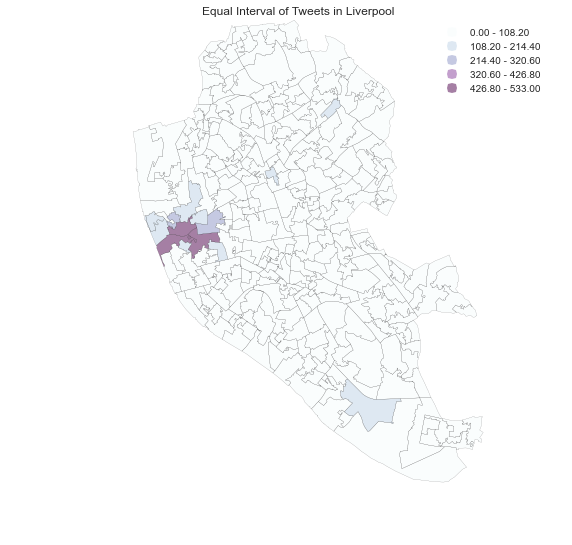

In [49]:
f, ax = plt.subplots(1, figsize=(9, 9))
lsoas.plot(column='tweet_count', scheme='equal_interval', legend=True, \
           axes=ax, colormap='BuPu', linewidth=0.1)
ax.set_axis_off()
ax.set_title("Equal Interval of Tweets in Liverpool")
plt.axis('equal')
plt.show()

Lecture figures:

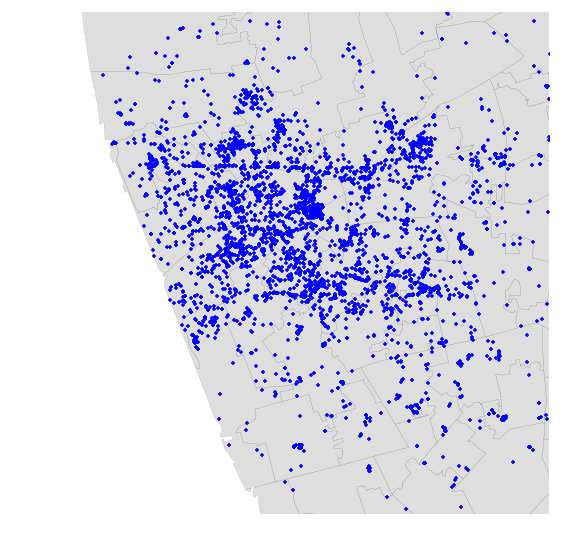

In [67]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, alpha=0.5, \
                                   edgecolor='0.25', facecolor='0.75', linewidth=0.1)
ax.plot(tw['X'], tw['Y'], marker='.', linewidth=0, color='b')
ax.set_axis_off()
plt.axis('equal')
ax.set_xlim(333000, 337000)
ax.set_ylim(388000, 392000)
plt.savefig('../lectures/figs/l09_liv_pts.png', dpi=300)
plt.show()

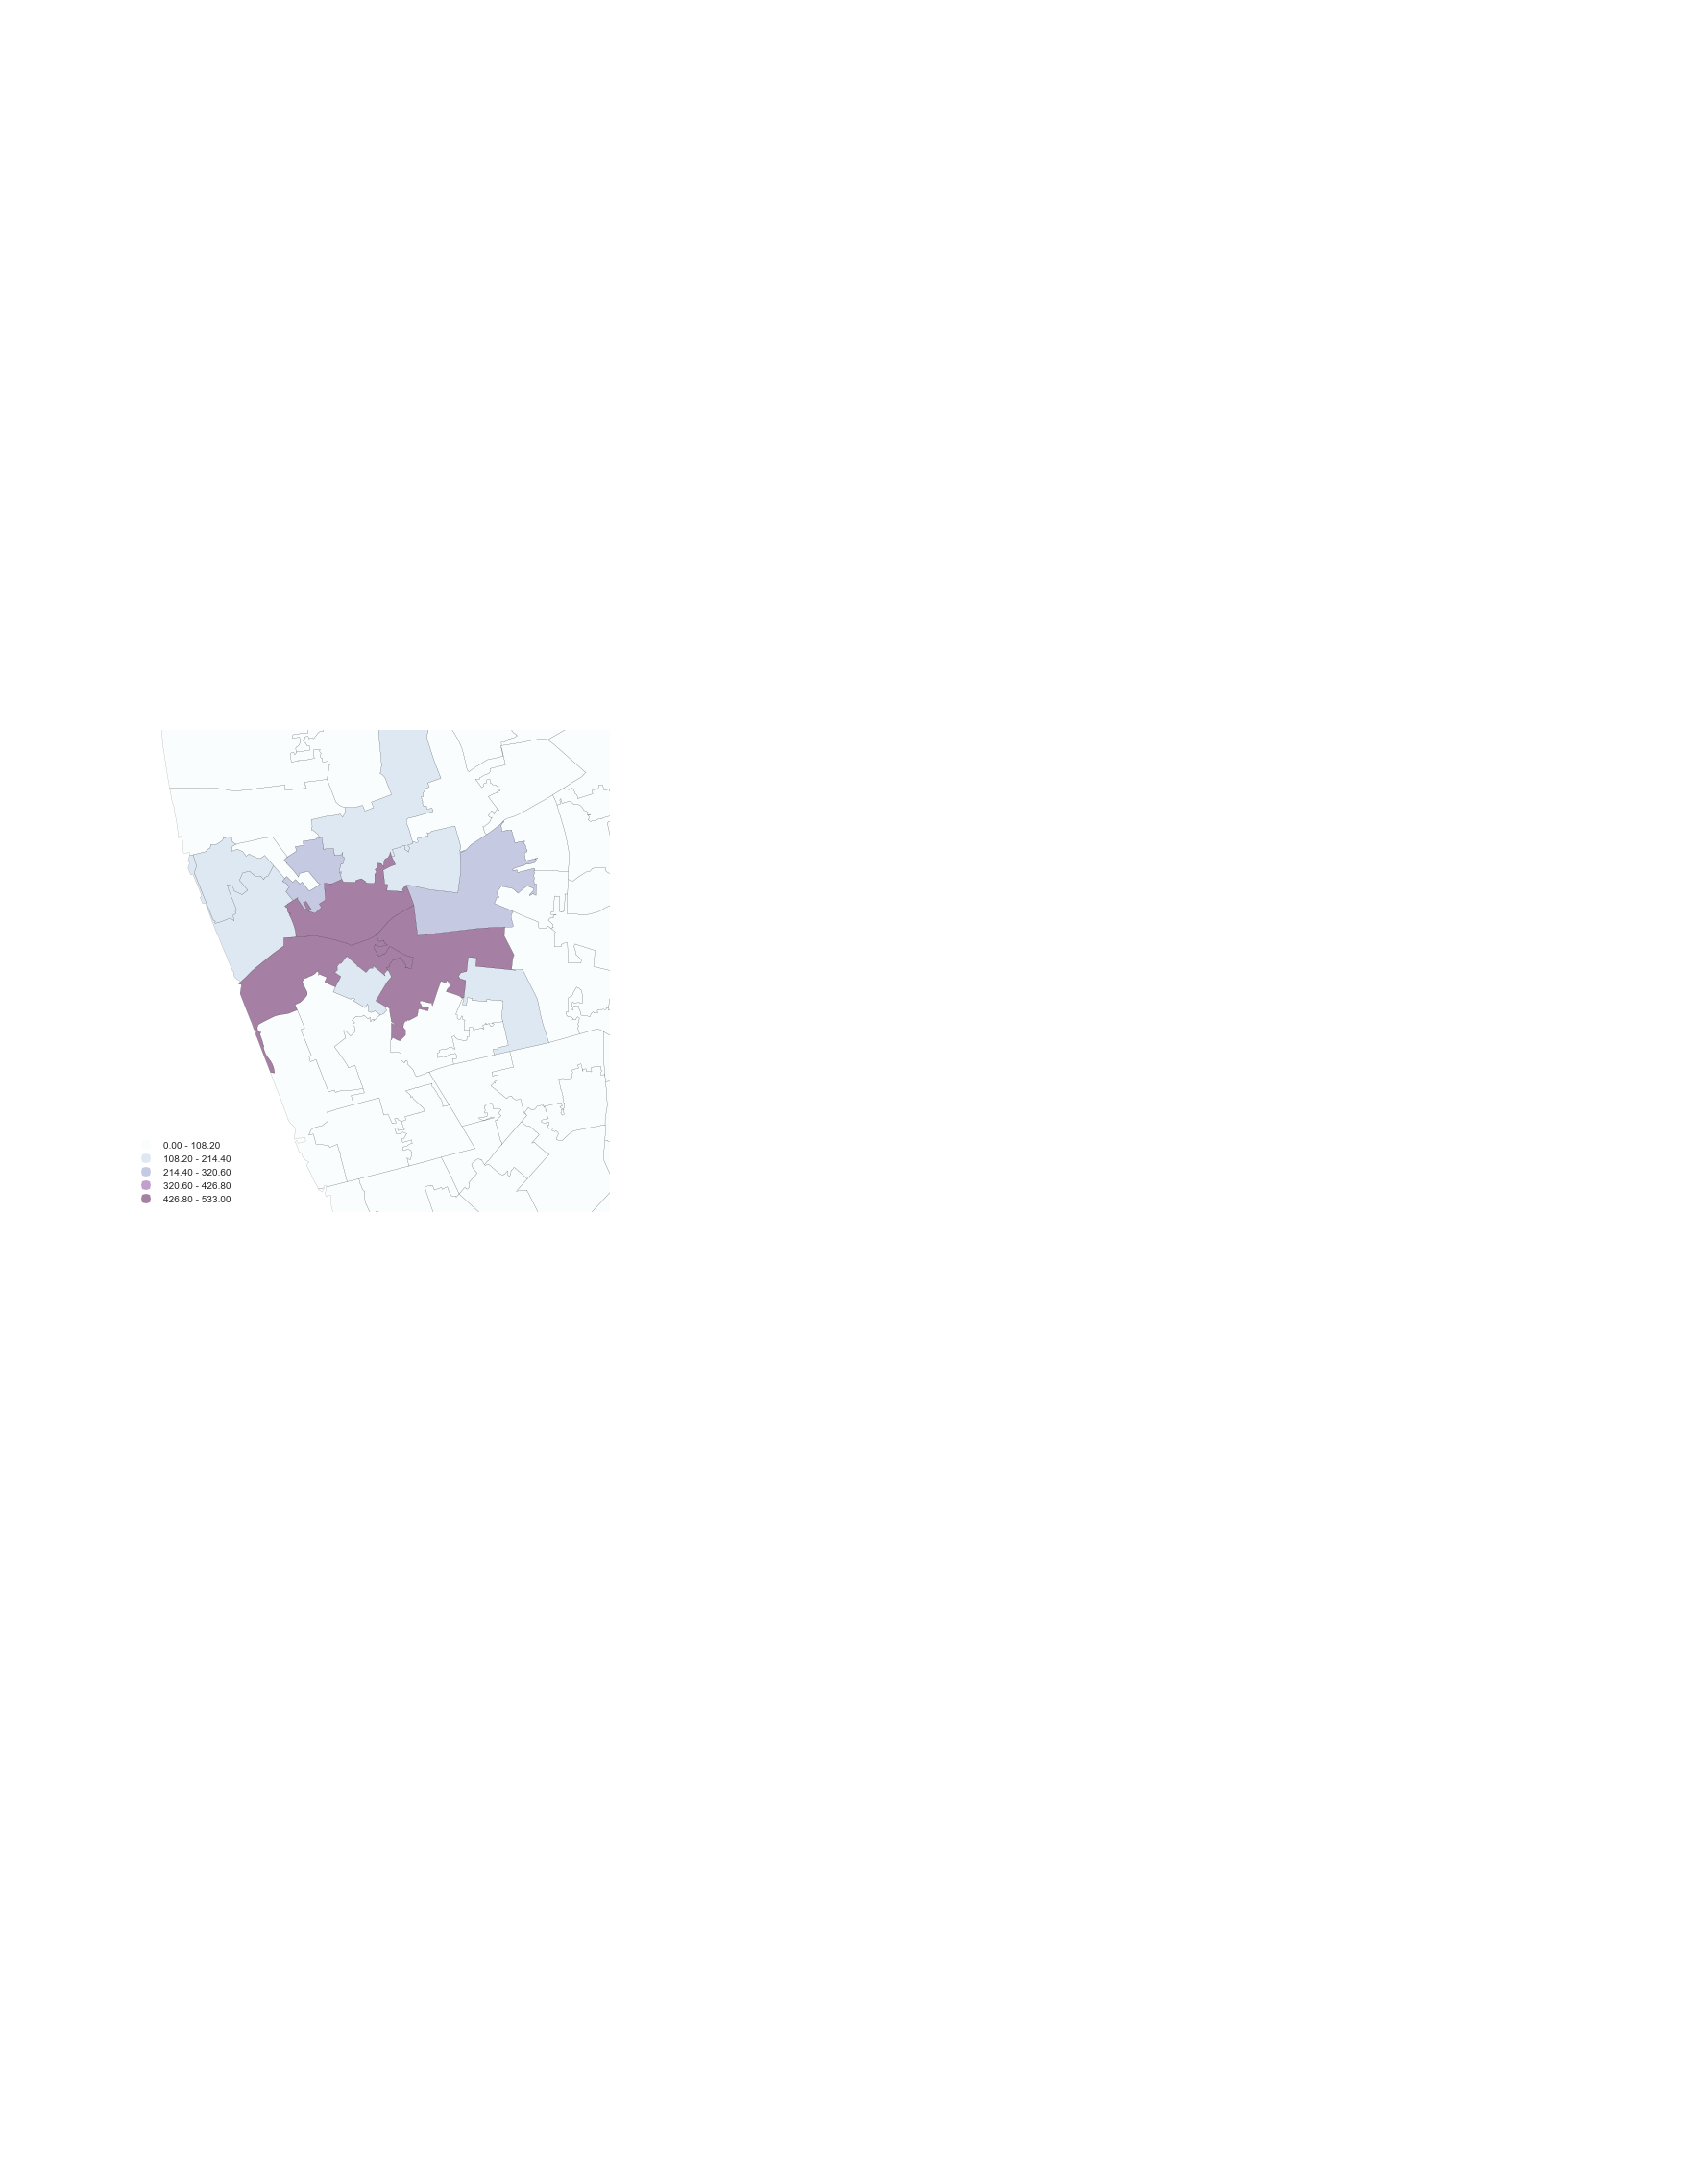

In [69]:
f, ax = plt.subplots(1, figsize=(9, 9))
lsoas.plot(column='tweet_count', scheme='equal_interval', legend=True, \
           axes=ax, colormap='BuPu', linewidth=0.1)
ax.set_axis_off()
plt.axis('equal')
ax.set_xlim(333000, 337000)
ax.set_ylim(388000, 392000)
plt.savefig('../lectures/figs/l09_liv_cho.png', dpi=300)
plt.show()

* Optional exercise: quantiles choropleth

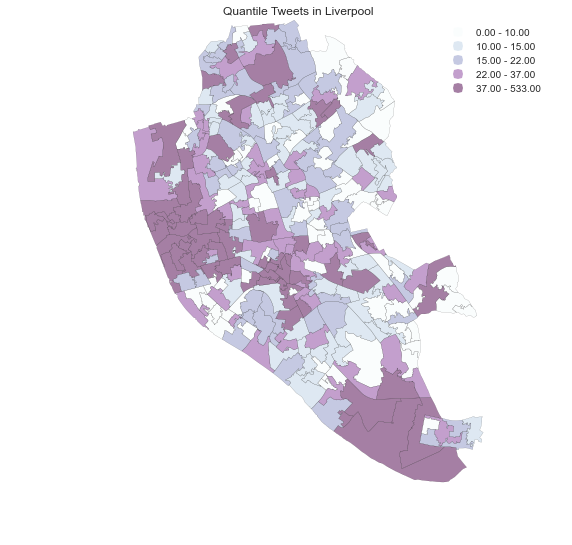

In [50]:
f, ax = plt.subplots(1, figsize=(9, 9))
lsoas.plot(column='tweet_count', scheme='quantiles', legend=True, \
           axes=ax, colormap='BuPu', linewidth=0.1)
ax.set_axis_off()
ax.set_title("Quantile Tweets in Liverpool")
plt.axis('equal')
plt.show()

#### Regular lattices: hex-binning

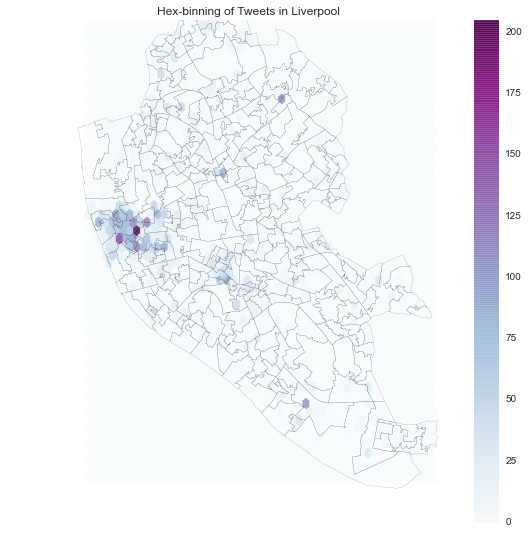

In [61]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='white', alpha=0, linewidth=0.1)
hb = ax.hexbin(tw.X, tw.Y, gridsize=50, alpha=0.8, cmap='BuPu')
plt.colorbar(hb)
ax.set_axis_off()
ax.set_title("Hex-binning of Tweets in Liverpool")
plt.axis('equal')
plt.show()

Lecture figures:

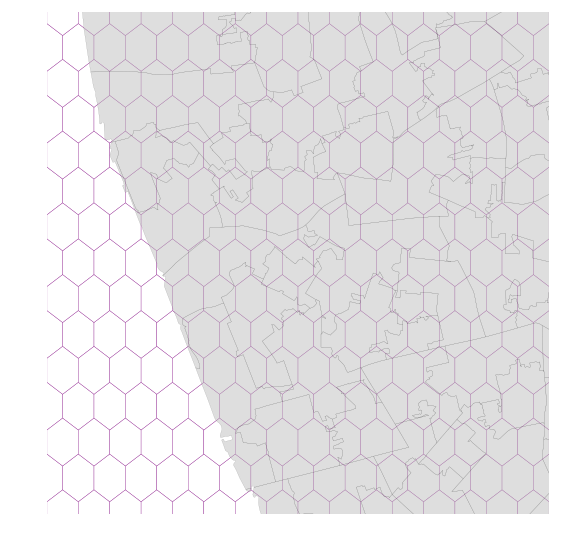

In [70]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, alpha=0.5, \
                                   edgecolor='0.25', facecolor='0.75', linewidth=0.1)
#hb = ax.hexbin(tw.X, tw.Y, gridsize=50, alpha=0.8, cmap='BuPu')
ax.hexbin(np.array([333000, 345500]), np.array([382000, 398000]), gridsize=50, edgecolors='purple')
ax.set_axis_off()
plt.axis('equal')
ax.set_xlim(333000, 337000)
ax.set_ylim(388000, 392000)
plt.savefig('../lectures/figs/l09_liv_hex_empty.png', dpi=300)
plt.show()

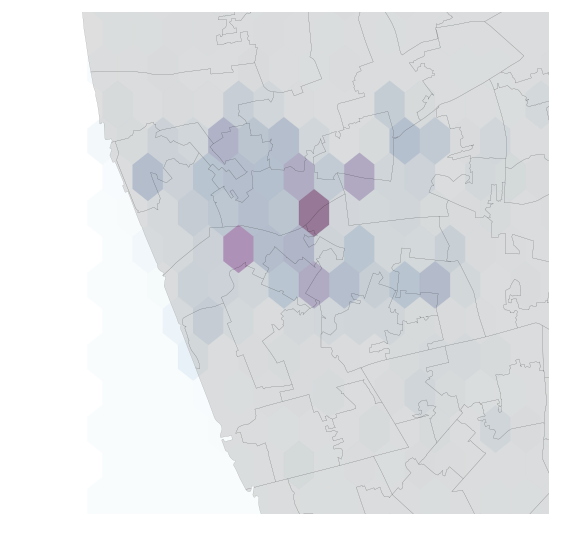

In [71]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, alpha=0.5, \
                                   edgecolor='0.25', facecolor='0.75', linewidth=0.1)
hb = ax.hexbin(tw.X, tw.Y, gridsize=50, alpha=0.8, cmap='BuPu')
ax.set_axis_off()
plt.axis('equal')
ax.set_xlim(333000, 337000)
ax.set_ylim(388000, 392000)
plt.savefig('../lectures/figs/l09_liv_hex_filled.png', dpi=300)
plt.show()

### Kernel Density Estimation

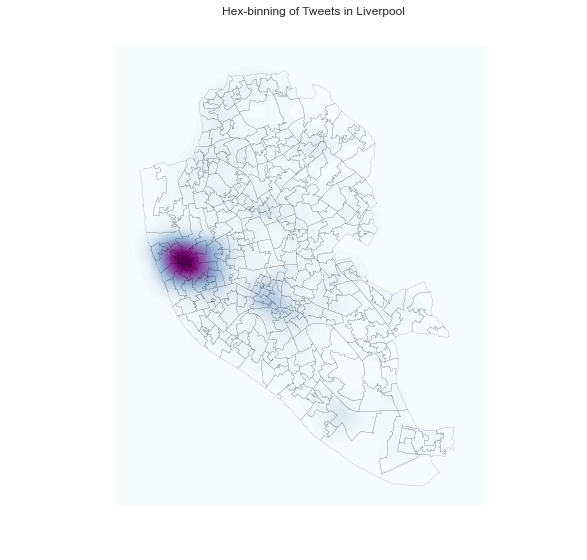

In [13]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='white', alpha=0, linewidth=0.1)
sns.kdeplot(tw['X'], tw['Y'], ax=ax, \
            n_levels=50, shade=True, cmap='BuPu')
ax.set_axis_off()
ax.set_title("Hex-binning of Tweets in Liverpool")
plt.axis('equal')
plt.show()

Lecture figures:

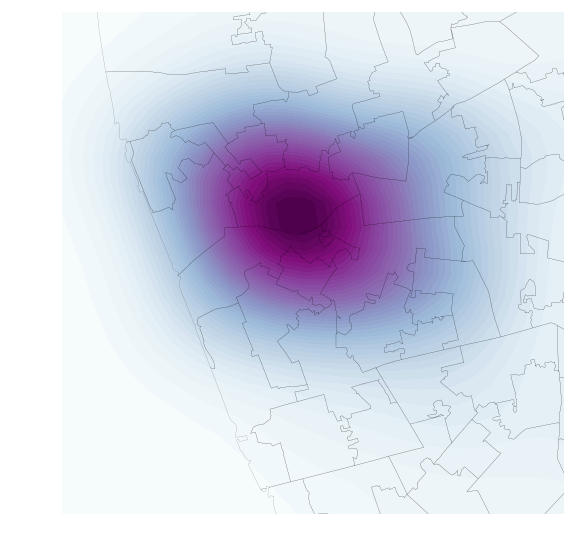

In [73]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='white', alpha=0, linewidth=0.1)
sns.kdeplot(tw['X'], tw['Y'], ax=ax, \
            n_levels=50, shade=True, cmap='BuPu')
ax.set_axis_off()
plt.axis('equal')
ax.set_xlim(333000, 337000)
ax.set_ylim(388000, 392000)
plt.savefig('../lectures/figs/l09_liv_kde.png', dpi=300)
plt.show()

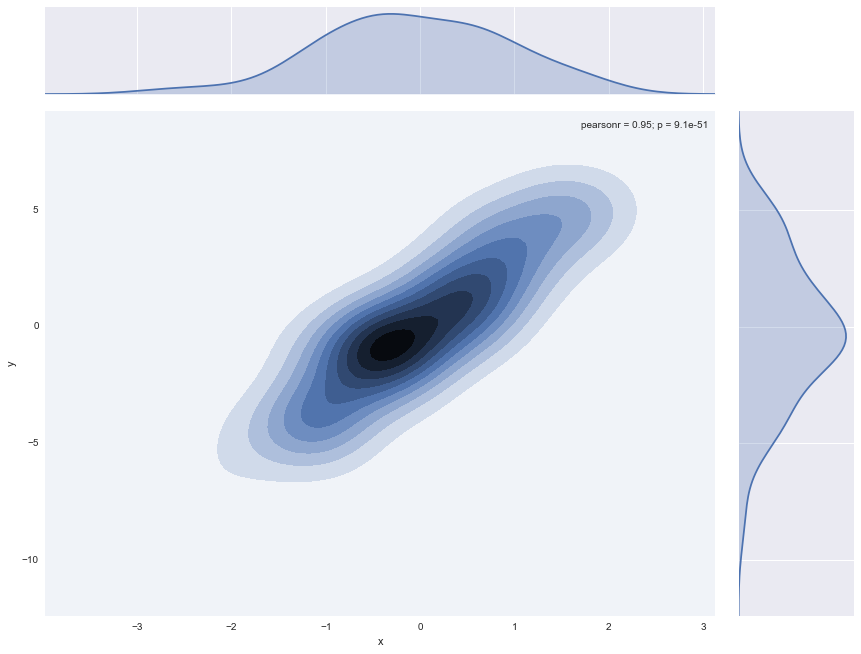

In [85]:
x = np.random.normal(size=100)
y = 3*x + np.random.normal(size=100)
df = pd.DataFrame({'x': x, 'y': y})
sns.jointplot(x="x", y="y", data=df, kind="kde")
fig = plt.gcf()
fig.set_size_inches(12.9, 9.6)
fig.savefig('../lectures/figs/l09_kde2d.png', dpi=300)

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'15 - Lab 6</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

